<a href="https://colab.research.google.com/github/Raaghashree/Pattern-Based-Insider-Threat-Detection-Using-Machine-Learning/blob/main/Unsupervised_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Dataset'

 CTDAPD_Anomaly_Ensembled.csv   device.csv	   logon.csv
'CTDAPD Dataset.csv'	        http.csv	   Processed_Unsupervised_CTDAPD_Dataset.csv
'CTDAPD Dataset.gsheet'         LDAP_2009-12.csv   readme.txt


In [ ]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE

# Load dataset
try:
    df = pd.read_csv("/content/drive/MyDrive/Dataset/CTDAPD Dataset.csv")
    print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("Error: 'CTDAPD Dataset.csv' file not found. Please check the file path.")
    exit(1)

# Step 1: Clean Column Names
df.columns = df.columns.str.strip()

# Step 2: Handle Missing Values
missing_percentage = df.isnull().mean() * 100
print(f"Columns with missing values: {missing_percentage[missing_percentage > 0].to_dict()}")

# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill numeric columns with mean, non-numeric with mode
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()) if col.isnull().sum() > 0 else col)

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]) if col.isnull().sum() > 0 else col)

# Step 3: Remove Duplicate Rows
duplicates = df.duplicated().sum()
print(f"Found {duplicates} duplicate rows")
df.drop_duplicates(inplace=True)

# Step 4: Handle Non-Numeric Columns
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Original non-numeric columns:", non_numeric_cols)

# Specify columns to keep among non-numeric: 'Label', 'Source_IP', 'Destination_IP', 'Protocol_Type', 'System_Patch_Status'
keep_columns = ['Label', 'Source_IP', 'Destination_IP', 'Protocol_Type', 'System_Patch_Status']
# Drop all non-numeric columns that are not in keep_columns
cols_to_drop = [col for col in non_numeric_cols if col not in keep_columns]
print(f"Non-numeric columns that will be dropped: {cols_to_drop}")
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Convert IP addresses into numeric form
if 'Source_IP' in df.columns:
    df['Source_IP_int'] = df['Source_IP'].apply(lambda ip: int(ipaddress.IPv4Address(ip)))
if 'Destination_IP' in df.columns:
    df['Destination_IP_int'] = df['Destination_IP'].apply(lambda ip: int(ipaddress.IPv4Address(ip)))
# Drop original IP columns
df.drop(columns=['Source_IP', 'Destination_IP'], inplace=True)

# Encode 'Protocol_Type' using LabelEncoder
if 'Protocol_Type' in df.columns:
    proto_encoder = LabelEncoder()
    df['Protocol_Type'] = proto_encoder.fit_transform(df['Protocol_Type'])
    print("Encoded 'Protocol_Type'.")

# ✅ Encode 'System_Patch_Status' using LabelEncoder
if 'System_Patch_Status' in df.columns:
    print(f"Encoding 'System_Patch_Status'. Original values: {df['System_Patch_Status'].unique()}")
    patch_encoder = LabelEncoder()
    df['System_Patch_Status'] = patch_encoder.fit_transform(df['System_Patch_Status'])
    print(f"Encoded values: {df['System_Patch_Status'].unique()}")

# Step 5: Encode Target Variable
if 'Label' in df.columns:
    if df['Label'].dtype == 'object':
        print(f"Encoding target variable. Original values: {df['Label'].unique()}")
        encoder = LabelEncoder()
        df['Label'] = encoder.fit_transform(df['Label'])
        print(f"Encoded values: {df['Label'].unique()}")
else:
    print("Error: Target column 'Label' not found in dataset")
    exit(1)

# Step 6: Ensure All Features Are Numeric
X = df.drop(columns=['Label'])
y = df['Label']

# 💡 Function to clean inf values in a specific column
def clean_feature_column(X):
    col = 'Normalized_Packet_Flow'
    if col in X.columns:
        mean_val = X[col][~np.isinf(X[col])].mean()
        X[col] = X[col].replace([np.inf, -np.inf], mean_val)
    return X

# ✅ Apply the fix for 'inf' values
X = clean_feature_column(X)

# Step 7: Handle Class Imbalance using SMOTE
class_counts = y.value_counts()
print(f"Class distribution before SMOTE: {class_counts.to_dict()}")
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio < 0.5:
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Fully balance classes
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Data shape after SMOTE: {X_resampled.shape}")
else:
    print("Class balance is acceptable, skipping SMOTE")
    X_resampled, y_resampled = X, y

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['Label'] = y_resampled

# Check new class distribution
print(f"Class distribution after SMOTE: {df_balanced['Label'].value_counts().to_dict()}")

# Step 8: Normalize Features using MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df_balanced.drop(columns=['Label']))
df_processed = pd.DataFrame(X_normalized, columns=X.columns)
df_processed['Label'] = df_balanced['Label']

# Save the cleaned and preprocessed dataset
df_processed.to_csv("Processed_CTDAPD_Dataset.csv", index=False)
print("\nData Preprocessing Complete! Cleaned dataset saved as 'Processed_CTDAPD_Dataset.csv'.")
print(f"Final dataset shape: {df_processed.shape}")

Dataset loaded successfully with 54768 rows and 30 columns
Columns with missing values: {'Attack_Vector': 80.03761320479111, 'Botnet_Family': 89.87547472976921, 'Malware_Type': 94.1261320479112}
Found 0 duplicate rows
Original non-numeric columns: ['Date', 'Source_IP', 'Destination_IP', 'Protocol_Type', 'Attack_Severity', 'System_Patch_Status', 'Label']
Non-numeric columns that will be dropped: ['Date', 'Attack_Severity']
Encoded 'Protocol_Type'.
Encoding 'System_Patch_Status'. Original values: ['Outdated' 'Up-to-date']
Encoded values: [0 1]
Encoding target variable. Original values: ['Normal' 'Attack']
Encoded values: [1 0]
Class distribution before SMOTE: {1: 46589, 0: 8179}
Class imbalance ratio: 0.18
Applying SMOTE to balance classes...
Data shape after SMOTE: (93178, 24)
Class distribution after SMOTE: {1: 46589, 0: 46589}

Data Preprocessing Complete! Cleaned dataset saved as 'Processed_CTDAPD_Dataset.csv'.
Final dataset shape: (93178, 25)


In [ ]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load dataset (change path accordingly if on Google Drive)
file_path = "/content/drive/MyDrive/Dataset/CTDAPD Dataset.csv"  # ✅ Update if needed
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded: {df.shape}")
except FileNotFoundError:
    print("Error: File not found.")
    exit(1)

# Step 1: Clean Column Names
df.columns = df.columns.str.strip()

# Step 2: Handle Missing Values
missing_percentage = df.isnull().mean() * 100
print("Missing Values:", missing_percentage[missing_percentage > 0].to_dict())

df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)  # Drop columns with >50% missing
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()) if col.isnull().sum() > 0 else col)

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]) if col.isnull().sum() > 0 else col)

# Step 3: Remove Duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
df.drop_duplicates(inplace=True)

# Step 4: Handle Non-Numeric Columns
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

# Keep useful object columns only
keep_columns = ['Source_IP', 'Destination_IP', 'Protocol_Type', 'System_Patch_Status']
cols_to_drop = [col for col in non_numeric_cols if col not in keep_columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Convert IPs to integers
if 'Source_IP' in df.columns:
    df['Source_IP_int'] = df['Source_IP'].apply(lambda ip: int(ipaddress.IPv4Address(ip)))
if 'Destination_IP' in df.columns:
    df['Destination_IP_int'] = df['Destination_IP'].apply(lambda ip: int(ipaddress.IPv4Address(ip)))
df.drop(columns=['Source_IP', 'Destination_IP'], inplace=True, errors='ignore')

# Encode categorical fields
if 'Protocol_Type' in df.columns:
    df['Protocol_Type'] = LabelEncoder().fit_transform(df['Protocol_Type'])

if 'System_Patch_Status' in df.columns:
    df['System_Patch_Status'] = LabelEncoder().fit_transform(df['System_Patch_Status'])

# Step 5: Drop Label Column (for unsupervised)
if 'Label' in df.columns:
    df.drop(columns=['Label'], inplace=True)
    print("Dropped 'Label' column for unsupervised learning")

# Step 6: Replace inf/-inf values
if 'Normalized_Packet_Flow' in df.columns:
    col = 'Normalized_Packet_Flow'
    mean_val = df[col][~np.isinf(df[col])].mean()
    df[col] = df[col].replace([np.inf, -np.inf], mean_val)

# Step 7: Normalize Features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df)
df_processed = pd.DataFrame(X_normalized, columns=df.columns)

# Save final dataset
df_processed.to_csv("Processed_Unsupervised_CTDAPD_Dataset.csv", index=False)
print("✅ Dataset ready for unsupervised learning!")
print(f"Final shape: {df_processed.shape}")


Dataset loaded: (54768, 30)
Missing Values: {'Attack_Vector': 80.03761320479111, 'Botnet_Family': 89.87547472976921, 'Malware_Type': 94.1261320479112}
Duplicate rows found: 0
Non-numeric columns: ['Date', 'Source_IP', 'Destination_IP', 'Protocol_Type', 'Attack_Severity', 'System_Patch_Status', 'Label']
✅ Dataset ready for unsupervised learning!
Final shape: (54768, 24)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Load preprocessed dataset
df = pd.read_csv("/content/Processed_Unsupervised_CTDAPD_Dataset.csv")

# Keep a copy of the original for saving
df_result = df.copy()

# --------------------- Hyperparameter Tuning for Isolation Forest ---------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.8],
    'contamination': [0.05, 0.1],
    'max_features': [1.0, 0.8]
}

grid = GridSearchCV(
    IsolationForest(random_state=42),
    param_grid,
    scoring='accuracy',  # not perfect for unsupervised but helps filter bad params
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Temporarily simulate labels for GridSearch scoring
# In unsupervised learning we assume most data is normal
pseudo_labels = np.zeros(len(df))
grid.fit(df, pseudo_labels)

best_iforest = grid.best_estimator_
print(f"\n✅ Best Isolation Forest Params: {grid.best_params_}")

# Predict with tuned Isolation Forest
iforest_pred = best_iforest.fit_predict(df)

# --------------------- Apply Local Outlier Factor ---------------------
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof_model.fit_predict(df)

# --------------------- Ensemble Voting ---------------------
# If both predict -1 (anomaly), final = -1
ensemble_pred = np.where((iforest_pred == -1) & (lof_pred == -1), -1, 1)

# Save results
df_result['IsolationForest'] = iforest_pred
df_result['LOF'] = lof_pred
df_result['Final_Anomaly_Label'] = ensemble_pred
df_result['Final_Anomaly_Label'] = df_result['Final_Anomaly_Label'].map({-1: 'Anomaly', 1: 'Normal'})

# Count
n_anomalies = (ensemble_pred == -1).sum()
print(f"\n🔍 Ensemble Detected {n_anomalies} anomalies out of {len(df)} samples.")
print(f"✅ Anomaly Percentage: {(n_anomalies / len(df)) * 100:.2f}%")

# Save to CSV
df_result.to_csv("CTDAPD_Anomaly_Ensembled.csv", index=False)
print("📁 Saved to 'CTDAPD_Anomaly_Ensembled.csv'")


Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Best Isolation Forest Params: {'contamination': 0.05, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}

🔍 Ensemble Detected 936 anomalies out of 54768 samples.
✅ Anomaly Percentage: 1.71%
📁 Saved to 'CTDAPD_Anomaly_Ensembled.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load data
df = pd.read_csv("/content/Processed_Unsupervised_CTDAPD_Dataset.csv")

# Optional: Extract ground truth if available
true_labels = pd.read_csv("/content/drive/MyDrive/Dataset/CTDAPD Dataset.csv")['Label'].map({'Normal': 0, 'Attack': 1})

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)

# Define Autoencoder
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

# Reconstruct and compute MSE
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Set threshold: top 5% MSE values are anomalies
threshold = np.percentile(mse, 95)
anomaly_pred = np.where(mse > threshold, 1, 0)  # 1 = Anomaly, 0 = Normal

# Save result
df['Autoencoder_Anomaly'] = np.where(anomaly_pred == 1, 'Anomaly', 'Normal')
df.to_csv("CTDAPD_Autoencoder_Results.csv", index=False)
print("📁 Results saved to 'CTDAPD_Autoencoder_Results.csv'")

# Optional: Evaluate if labels are available
if true_labels is not None:
    print("\n📊 Classification Report:")
    print(classification_report(true_labels, anomaly_pred, target_names=['Normal', 'Attack']))


Epoch 1/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0595 - val_loss: 0.0114
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - val_loss: 8.7979e-04
Epoch 9/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2913e-04 - val_loss: 6.9269e-04
Epoch 10/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6602e-04 - val_loss: 5.9108e-04
Epoch 11/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6281e-04 - val_loss: 5.0567e-04
Epoch 12/50
193/193 ━━━━


📊 Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.95      0.90     46589
      Attack       0.16      0.05      0.08      8179

    accuracy                           0.82     54768
   macro avg       0.50      0.50      0.49     54768
weighted avg       0.75      0.82      0.78     54768


🧮 Confusion Matrix:
[[44277  2312]
 [ 7752   427]]


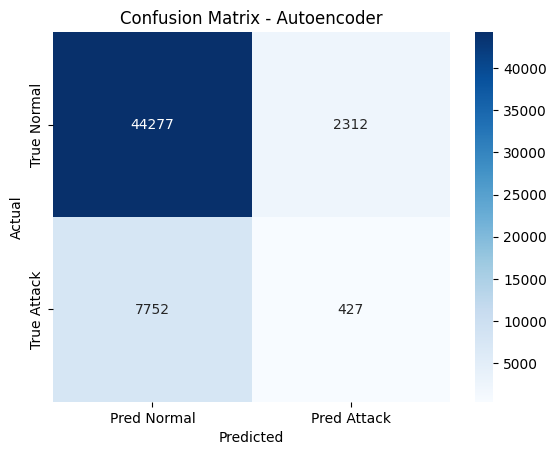

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Load results from previous Autoencoder model
df_result = pd.read_csv("/content/CTDAPD_Autoencoder_Results.csv")

# Load true labels from the original dataset
true_labels = pd.read_csv("/content/drive/MyDrive/Dataset/CTDAPD Dataset.csv")['Label'].map({'Normal': 0, 'Attack': 1})

# Convert predicted labels to binary
predicted_labels = df_result['Autoencoder_Anomaly'].map({'Normal': 0, 'Anomaly': 1})

# --- Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Attack']))

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, predicted_labels)
print("\n🧮 Confusion Matrix:")
print(cm)

# Optional: Visualize Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Normal', 'Pred Attack'], yticklabels=['True Normal', 'True Attack'])
plt.title("Confusion Matrix - Autoencoder")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import joblib

# Step 6: Save the trained autoencoder model
joblib.dump(autoencoder, "autoencoder_cyber_model.pkl")
print("\n🚀 Trained Autoencoder model saved as 'autoencoder_cyber_model.pkl'")



🚀 Trained Autoencoder model saved as 'autoencoder_cyber_model.pkl'


In [ ]:
from google.colab import files
files.download("autoencoder_cyber_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

New Model training

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Dataset'

 CTDAPD_Anomaly_Ensembled.csv	  hr_ldap_ad_dataset_with_roles.csv
 CTDAPD_Autoencoder_Results.csv   http.csv
 CTDAPD_Dataset.csv		  LDAP_2009-12.csv
 CTDAPD_Dataset.gsheet		  logon.csv
 device.csv			  ML_DATA
 FINAL				  Processed_Unsupervised_CTDAPD_Dataset.csv
'FOR MODELS'			  readme.txt
 hr_ldap_ad_dataset.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Load dataset
df = pd.read_csv("/content/drive/MyDrive/Dataset/FOR MODELS/unified_logs_dataset_preprocessed.csv")

# Step 2: Drop the label column (for unsupervised learning)
if 'suspicious' in df.columns:
    df = df.drop(columns=['suspicious'])

# Step 3: Drop non-numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Step 4: Handle missing values
df_numeric = df_numeric.dropna()  # or use df_numeric.fillna(method='ffill')

# Step 5: Normalize numeric features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Step 6: Save cleaned dataset
df_scaled.to_csv("/content/drive/MyDrive/Dataset/FOR MODELS/unsupervised_dataset_cleaned.csv", index=False)
print("✅ Cleaned dataset saved as 'unsupervised_dataset_cleaned.csv'")


✅ Cleaned dataset saved as 'unsupervised_dataset_cleaned.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Load the cleaned dataset
df = pd.read_csv("/content/drive/MyDrive/Dataset/FOR MODELS/unsupervised_dataset_cleaned.csv")

# -------------------- Isolation Forest --------------------
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_preds = iso_forest.fit_predict(df)  # -1 = anomaly

# -------------------- Local Outlier Factor --------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_preds = lof.fit_predict(df)  # -1 = anomaly

# -------------------- Ensemble Voting --------------------
ensemble_preds = np.where((iso_preds == -1) & (lof_preds == -1), -1, 1)

# Save results to new DataFrame
df_result = df.copy()
df_result["IsolationForest"] = iso_preds
df_result["LOF"] = lof_preds
df_result["Final_Anomaly_Label"] = np.where(ensemble_preds == -1, "Anomaly", "Normal")

# Save to CSV
output_path = "/content/drive/MyDrive/Dataset/FOR MODELS/unsupervised_anomaly_results.csv"
df_result.to_csv(output_path, index=False)

# Summary
n_anomalies = np.sum(ensemble_preds == -1)
print(f"\n🔍 Detected {n_anomalies} anomalies out of {len(df)} samples.")
print(f"📁 Results saved to: {output_path}")


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(



🔍 Detected 111 anomalies out of 29994 samples.
📁 Results saved to: /content/drive/MyDrive/Dataset/FOR MODELS/unsupervised_anomaly_results.csv


Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.9785 - val_loss: 0.8352
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8252 - val_loss: 0.8162
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8079 - val_loss: 0.8077
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7991 - val_loss: 0.8054
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.8026 - val_loss: 0.8048
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.7955 - val_loss: 0.8047
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.7972 - val_loss: 0.8046
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7981 - val_loss: 0.8044
Epoch 9/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8005 - val_loss: 0.8042
Epoch 10/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7977 - val_loss: 0.8046
Epoch 11/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8013 - val_loss: 0.8043
Epoch 12/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
📊 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.98     29883
      Attack       0.05      0.72      0.10       111

    accuracy                           0.95     29994
   macro avg       0.53      0.84      0.54     29994
weighted avg       1.00      0.95      0.97     29994

🧮 Confusion Matrix:
[[28465  1418]
 [   31    80]]


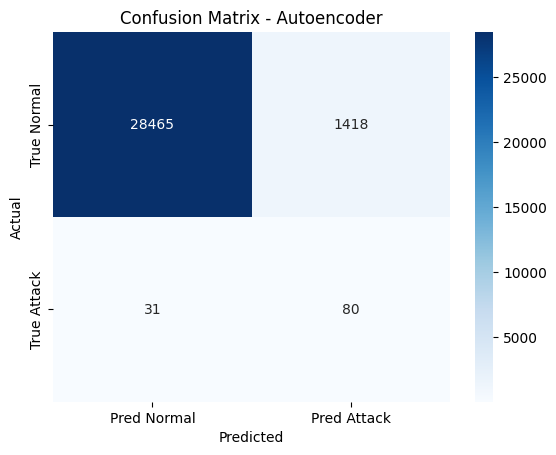


✅ Autoencoder training complete and saved.


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load data and exclude labels
df = pd.read_csv("/content/drive/MyDrive/Dataset/FOR MODELS/unsupervised_anomaly_results.csv")
X = df.drop(columns=["IsolationForest", "LOF", "Final_Anomaly_Label"])
y_true = df["Final_Anomaly_Label"]  # True labels

# Convert y_true to numeric labels (0 for "Normal" and 1 for "Attack")
y_true = y_true.map({"Normal": 0, "Anomaly": 1})

# Step 2: Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Define Autoencoder architecture
input_dim = X_scaled.shape[1]
encoding_dim = input_dim // 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
encoded = Dense(encoding_dim // 2, activation="relu")(encoded)
decoded = Dense(encoding_dim, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Step 4: Train Autoencoder
early_stop = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
autoencoder.fit(X_scaled, X_scaled,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                callbacks=[early_stop],
                verbose=1)

# Step 5: Save model and scaler
autoencoder.save("/content/drive/MyDrive/Dataset/FOR MODELS/autoencoder_trained_unsupervised.h5")
joblib.dump(scaler, "/content/drive/MyDrive/Dataset/FOR MODELS/autoencoder_scaler_unsupervised.pkl")

# Step 6: Reconstruct the input data using the autoencoder
X_reconstructed = autoencoder.predict(X_scaled)

# Step 7: Calculate the reconstruction error (MSE) for each data point
mse = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# Step 8: Define a threshold for anomaly detection (e.g., 95th percentile of MSE)
threshold = np.percentile(mse, 95)

# Step 9: Classify the data points based on the reconstruction error
y_pred = [1 if error > threshold else 0 for error in mse]  # 1 for "Attack", 0 for "Normal"

# Step 10: Generate classification report and confusion matrix
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Attack"]))

print("🧮 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# --- Visualize Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Normal', 'Pred Attack'], yticklabels=['True Normal', 'True Attack'])
plt.title("Confusion Matrix - Autoencoder")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("\n✅ Autoencoder training complete and saved.")


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Dataset/FOR MODELS/autoencoder_scaler_unsupervised.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Unsupevised ML Model for** **system_runtime_behaviour_logs**

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset from your Drive path
df = pd.read_csv("/content/drive/MyDrive/Dataset/FOR MODELS/system_runtime_behavior_logs.csv")

# Drop non-informative or identifier columns
df_unsupervised = df.drop(columns=["label", "container_id", "timestamp", "user_id", "username"])

# One-hot encode categorical columns
categorical_cols = ["syscall", "file", "network_activity"]
df_encoded = pd.get_dummies(df_unsupervised, columns=categorical_cols)

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Save the preprocessed data
preprocessed_df = pd.DataFrame(X_scaled, columns=df_encoded.columns)
preprocessed_df.to_csv("/content/drive/MyDrive/Dataset/FOR MODELS/processed_unsupervised_data.csv", index=False)

print("✅ Preprocessed data saved to 'processed_unsupervised_data.csv'")


✅ Preprocessed data saved to 'processed_unsupervised_data.csv'


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Dataset/FOR MODELS/system_runtime_behavior_logs.csv")

# Drop irrelevant or non-numeric columns
df = df.drop(columns=["container_id", "timestamp", "user_id", "username"])

# Encode categorical columns
label_encoders = {}
for col in ["syscall", "file", "network_activity"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate features and labels
X = df.drop(columns=["label"])
y_true = df["label"]  # Only used for evaluation, not training

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_scaled)

# Save model and scaler
joblib.dump(model, "/content/drive/MyDrive/Dataset/FOR MODELS/isolation_forest_model.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/Dataset/FOR MODELS/isolation_forest_scaler.pkl")

print("\n✅ Isolation Forest model training complete and saved.")



✅ Isolation Forest model training complete and saved.


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import joblib

# Step 1: Load dataset and preprocess data
df = pd.read_csv("/content/drive/MyDrive/Dataset/FOR MODELS/system_runtime_behavior_logs.csv")

# Drop irrelevant or non-numeric columns
df = df.drop(columns=["container_id", "timestamp", "user_id", "username"])

# Encode categorical columns using Label Encoding
label_encoders = {}
for col in ["syscall", "file", "network_activity"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate features and labels
X = df.drop(columns=["label"])
y_true = df["label"]  # Only used for evaluation, not training

# Step 2: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Initialize model and set number of epochs for training
epochs = 10  # Set the number of epochs
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Step 4: Train the model over multiple epochs (no classification report for each epoch)
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}...")

    # Fit the model (simulating one epoch of training)
    model.fit(X_scaled)

# Step 5: Predict anomalies after all epochs (Outlier = -1, Inlier = 1)
y_pred = model.predict(X_scaled)

# Convert predictions to 0 or 1 (Outlier = 1, Inlier = 0)
y_pred = [1 if val == -1 else 0 for val in y_pred]

# Step 6: Generate final Classification Report
print("📊 Final Classification Report:")
report = classification_report(y_true, y_pred, target_names=["Normal", "Attack"])
print(report)

# Step 7: Save the final model and scaler
joblib.dump(model, "/content/drive/MyDrive/Dataset/FOR MODELS/isolation_forest_final_model.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/Dataset/FOR MODELS/isolation_forest_final_scaler.pkl")

print("\n✅ Training complete with epochs. The final model and scaler are saved.")



Epoch 1/10...

Epoch 2/10...

Epoch 3/10...

Epoch 4/10...

Epoch 5/10...

Epoch 6/10...

Epoch 7/10...

Epoch 8/10...

Epoch 9/10...

Epoch 10/10...
📊 Final Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      0.94      0.65      1506
      Attack       0.42      0.04      0.08      1494

    accuracy                           0.49      3000
   macro avg       0.46      0.49      0.36      3000
weighted avg       0.46      0.49      0.37      3000


✅ Training complete with epochs. The final model and scaler are saved.


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Dataset/FOR MODELS/isolation_forest_final_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>